# Поиска инсайтов и точек роста для сервиса доставки еды "Всё.из.кафе"

- Автор: Смирнова Анастасия
- Дата: 02.07.2025

## Цели и задачи проекта

**Цель проекта** - исследовать данные сервиса доставки еды «Всё.из.кафе» для поиска инсайтов, которые позволят сервису повысить показатель удержания пользователей и улучшить взаимодействие с партнёрами.

В ходе исследования необходимо ответить на следующие вопросы:

- Как ведут себя пользователи? Как наиболее эффективно выстроить работу с ними, чтобы они продолжали пользоваться продуктом?
- Какой путь проходят пользователи в сервисе? Где «проваливаются»?
- Как улучшить взаимодействие с партнёрами-ресторанами?

**Задачи**:

- Изучить пользовательский путь и проанализируете конверсии через воронки;
- Сегментировать пользователей с помощью RFM-модели для оценки лояльности и поведения клиентов;
- Выделить кластеры ресторанов при помощи метода K-Means, чтобы выделить группы с разными моделями работы и разработать персонализированные маркетинговые стратегии.

## План проекта
- Загрузка данных и их предобработка.
- Анализ пользовательского пути новых пользователей.
- RFM сегментация.
- K-Means кластеризация.
- Итоговый вывод и рекомендации.

## Описание данных

Данные включают следующие сведения:
      
- `visitor_uuid` — идентификатор посетителя. Это идентификатор, который присваивается системой любому новому пользователю вне зависимости от того, зарегистрировался он в продукте или нет.
- `user_id` — идентификатор зарегистрированного пользователя. Присваивается посетителю после создания учётной записи: ввода логина, пароля, адреса доставки и контактных данных.
- `device_type` — тип платформы, с которой посетитель зашёл в продукт.
- `city_id` — город, из которого посетитель зашёл в сервис.
- `source` — рекламный источник привлечения посетителя.
- `first_date` — дата первого посещения продукта.
- `visit_id` — уникальный идентификатор сессии.
- `event` — название аналитического события.
- `datetime` — дата и время события.
- `rest_id` — уникальный идентификатор ресторана (заполняется для заказов, карточек ресторанов и блюд).
- `object_id` — уникальный идентификатор блюда (заполняется для заказов и карточек блюд).
- `order_id` — уникальный идентификатор заказа.
- `revenue` — выручка от заказа (в рублях). Это та сумма, которую пользователь видит при оплате.
- `delivery` — стоимость доставки (в рублях).
- `commission` — комиссия, которую «Всё.из.кафе» берёт с выручки ресторана, в процентах.


## 1. Загрузка данных и их предобработка

Зарузим данные и ознакомимся с ними. Для этого создадим функцию df_info, которая будет выводить следующую информацию:

- Количество строк;
- Количество столбцов;
- Типы данных;
- Содержимое первой строки;
- Доля пропусков в каждом столбце;
- Доля явных дубликатов.

In [1]:
#импортируем нужные библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import math

from sklearn.cluster import KMeans

In [2]:
#загружаем данные
source = 'https://code.s3.yandex.net/datasets/insides_data.csv'

data = pd.read_csv(source, parse_dates = ['first_date','datetime'])

In [3]:
#создаём функцию df_info
def df_info(df, df_name = None):
    """
    Выводит информацию о датасете

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
        df_name (str): Название датафрейма (для отображения).
    """

    print('-'*10,''*5,f'Информация о датафрейме {str(df_name)}: ', ''*5, '-'*10)
    print('')

    row_count = df.shape[0] #Возвращаем информацию о количестве строк
    print(f'1) Количество строк: {row_count}')

    column_count = df.shape[1] #Возвращаем информацию о количестве столбцов
    print(f'2) Количество столбцов: {column_count}')

    columns = df.dtypes #Возвращаем информацию столбцах и типах данных
    print('3) Типы данных:')
    print('')
    print(columns)
    print('')

    first_row = df.iloc[0, :] #Возвращаем первую строку датафрейма
    print(f'4) Первая строка:')
    print('')
    print(pd.Series(first_row))
    print('')

    is_null = df.isna().mean() * 100 #Возвращаем количество пропусков
    print(f'5) Доля пропусков в каждом из столбцов:')
    print('')
    print(is_null)
    print('')

    is_unique = df.duplicated().mean() * 100 #Возвращаем количество уникальных значений
    print(f'6) Полных дубликатов:')
    print('')
    print(is_unique)
    print('')
    print('-'*62)

In [4]:
#применяем функцию к датайрему data
df_info(data,'data')

----------  Информация о датафрейме data:   ----------

1) Количество строк: 205510
2) Количество столбцов: 15
3) Типы данных:

visitor_uuid            object
user_id                float64
device_type             object
city_id                  int64
source                  object
first_date      datetime64[ns]
visit_id                 int64
event                   object
datetime        datetime64[ns]
rest_id                 object
object_id              float64
order_id               float64
revenue                float64
delivery               float64
commission             float64
dtype: object

4) Первая строка:

visitor_uuid    01b5da38-3022-48ff-87c0-5519247fef1b
user_id                                     567317.0
device_type                                  Desktop
city_id                                            6
source                                      Source_B
first_date                       2021-05-01 00:00:00
visit_id                                   171481813
ev

Для оптимизации выполним понижение разрядности в столбцах, содержащих числовые данные при помощи функции `downcast`.

In [5]:
#создаём функцию
def downcast(df):
    """
    Выполняет понижение разрядности в столбцах датафрейма с типами данных
    int64 и float64

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    for dtype, column in zip(df.dtypes, df.columns):
        if dtype == 'int64':
            df[column] = pd.to_numeric(df[column], downcast = 'integer')
        elif dtype == 'float64':
            df[column] = pd.to_numeric(df[column], downcast = 'float')
    print('Результат понижения разрядности:')
    print('')
    return df.info()

In [6]:
#применяем функцию
downcast(data)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205510 entries, 0 to 205509
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   visitor_uuid  205510 non-null  object        
 1   user_id       205510 non-null  float32       
 2   device_type   205510 non-null  object        
 3   city_id       205510 non-null  int8          
 4   source        205510 non-null  object        
 5   first_date    205510 non-null  datetime64[ns]
 6   visit_id      205510 non-null  int32         
 7   event         205510 non-null  object        
 8   datetime      205510 non-null  datetime64[ns]
 9   rest_id       166915 non-null  object        
 10  object_id     21308 non-null   float32       
 11  order_id      7008 non-null    float32       
 12  revenue       7008 non-null    float64       
 13  delivery      7008 non-null    float32       
 14  commission    21308 non-null   flo

Улалось понизить разрядность практически во всех столбцах, содеращих числовые данные, что поможет сократить время обработки датафрейма.

Рассмотрим пропуски. В некотрых столбцах датафрейма доля пропусков достаточно высокая:

- `rest_id` - 18.78%;
- `object_id` - 89.63%;
- `order_id` - 96.59%;
- `revenue` - 96.59%;
- `delivery` - 96.59%;
- `commission` - 89.63%.

Вероятно, пропуски содержатся в тех характеристиках, которые не присваиваются определенному виду пользовательской активности. Например, на этапе `authorization` в поле `rest_id` будет пропуск, поскольку пользователь не взаимодействует с рестораном.

Проверим данную гипотезу. Для начала узнаем, данные о каких событиях содержатся в датафрейме.

In [7]:
#выводим данные о типах пользовательской активности
data['event'].value_counts()

,count
event,
main_page,145607
login,18581
object_page,12132
authorization,9983
reg_page,5684
add_to_cart,5627
confirm_phone,4347
order,3549


На основании названий этапов можно разделить их на три группы:

- Действия, связанные с регистрацией и авторизацией: `login`, `authorization`, `confirm_phone`;
- Действия, связанные с оформлением заказа: `add_to_cart`, `order`;
- Действия, связанные с навигацией: `main_page`, `object_page`, `reg_page`.

Теперь рассмотрим, для каких этапов характерно наличие пропусков в определенных полях.

In [8]:
for column in ['rest_id','object_id','order_id','revenue','delivery','commission']:
    print('')
    print(f'Количество пропусков для {column}:')
    print('')
    print(data[data[column].isna()].copy()['event'].value_counts().reset_index())
    print('_' * 35)


Количество пропусков для rest_id:

           event  count
0          login  18581
1  authorization   9983
2       reg_page   5684
3  confirm_phone   4347
___________________________________

Количество пропусков для object_id:

           event   count
0      main_page  145607
1          login   18581
2  authorization    9983
3       reg_page    5684
4  confirm_phone    4347
___________________________________

Количество пропусков для order_id:

           event   count
0      main_page  145607
1          login   18581
2    object_page   12132
3  authorization    9983
4       reg_page    5684
5  confirm_phone    4347
6    add_to_cart    2168
___________________________________

Количество пропусков для revenue:

           event   count
0      main_page  145607
1          login   18581
2    object_page   12132
3  authorization    9983
4       reg_page    5684
5  confirm_phone    4347
6    add_to_cart    2168
___________________________________

Количество пропусков для delivery:

  

Пропуски содеражтся в тех столбцах, которые характеризуют действия, свзанные с этапом оформления заказов.

Количество пропусков для этапов `main_pade`, `login`, `authorization`, `reg_page`, `confirm_phone` для каждого из рассматриваемых столбцов одинаково, что подтверждает гипотезу о том, что для данных этапов данные о совершении заказа не логируются, поскольку данные события связаны с процессами авторизации и регистрации пользователей в системе и не характерны для этапов, связанных с оформлением заказов.

Для этапа `add_to_cart` пропуски содержатся в столбцах `order_id`, `revenue` и `delivery`, что также логично, поскольку данные о номере заказа, выручке и стоимости доставки появляются уже после добавления блюда в корзину на этапе оформления заказа.

Таким образом, наличие пропусков не является подозрительным и связано со особенностями логирования каждого вида пользовательской активности.

Рассмотрим наличие дубликатов.
Первичная проверка показала отсутствие полных дубликатов, однако возможно появление дубликатов по конкретным событиям. Проверим наличие дубликатов по полям `user_id`, `device_type`, `datetime`, `event`.

In [9]:
#рассчитываем колчество дубликатов
duplicates = data.duplicated(subset = ['user_id','device_type','datetime','event']).sum()

print(f'Количество дубликатов по действиям пользователей в системе: {duplicates}')

Количество дубликатов по действиям пользователей в системе: 7


По всей видимости на некоторых этапах логирования произошла ошибка и данные были записаны дважды. Несмотря на то, что количество таких строк невелико, для корректности дальнейших расчетов, удалим такие данные.

In [10]:
#удаляем дубликаты
data = data.drop_duplicates(subset = ['user_id','device_type','datetime','event'])

### Вывод

Предобработка данных завершена. В результате было выполнено следующее:

- Выполнены преобразования типов данных в столбцах `first_date`, `datetime`, содержащих информацию о датах, к `datetime`;
- Выполнено понижение разрядности в столбцах, содержаших числовые данные;
- Выполнен анализ пропусков. Аномалий не выявлено. Наличие пропусков связано с особенностями логирования пользовательской активности;
- Удалено 7 дубликатов, дублирующих определенные этапы пользовательской активности.

Предобработка данных завершена. Можно приступать в основным расчетам.

---

## 2. Анализ пользовательского пути

По информации от маркетологов в последнее время было зафиксировано снижение количества заказов. При этом снижение количества скачиваний приложения зафиксировано не было. Было также зафиксировано увеличение доли заказов с десктопной версии приложения по сравнению с мобильной.

Возможно потеря пользователей происходит на этапе подтверждения номера телефона в связи с недавним изменением алгоритма подтверждения номера телефона и адреса доставки.

Пользовательский путь от авторазации до оформления заказа можно описать через следующие этапы:

1. `authorization` — авторизация пользователя — запуск приложения.
2. `main_page` — загрузка основной страницы приложения.
2. `reg_page` — переход на страницу регистрации.
2. `confirm_phone` — подтверждение телефона (окончание процесса регистрации).
2. `object_page` — страница блюда.
2. `add_to_cart` — переход в корзину.
2. `order` — оформление заказа.

Построим две воронки конверсии - классическую и step by step для того, чтобы понять, происходит ли заметный отток пользователей на каком-то из этапов взаимодействия с приложением.

### **Задача 2.1.** Построение классической и step by step воронки

In [11]:
#задаем порядок шагов в воронке
steps = ['authorization', 'main_page', 'reg_page', 'confirm_phone', 'object_page', 'add_to_cart', 'order']

#фильтруем данные по релеватным действиям
funnel_data = data[data['event'].isin(steps)].copy()

#рассчитываем количество пользователей для каждого этапа
funnel = funnel_data.groupby('event')['user_id'].nunique().reindex(steps).reset_index(name = 'user_count')

#рассчитываем конверсии
funnel['classic'] = (funnel['user_count'] / funnel['user_count'].iloc[0] * 100).round(1)
funnel['step_by_step'] = (funnel['user_count'] / funnel['user_count'].shift(1) * 100).round(1)

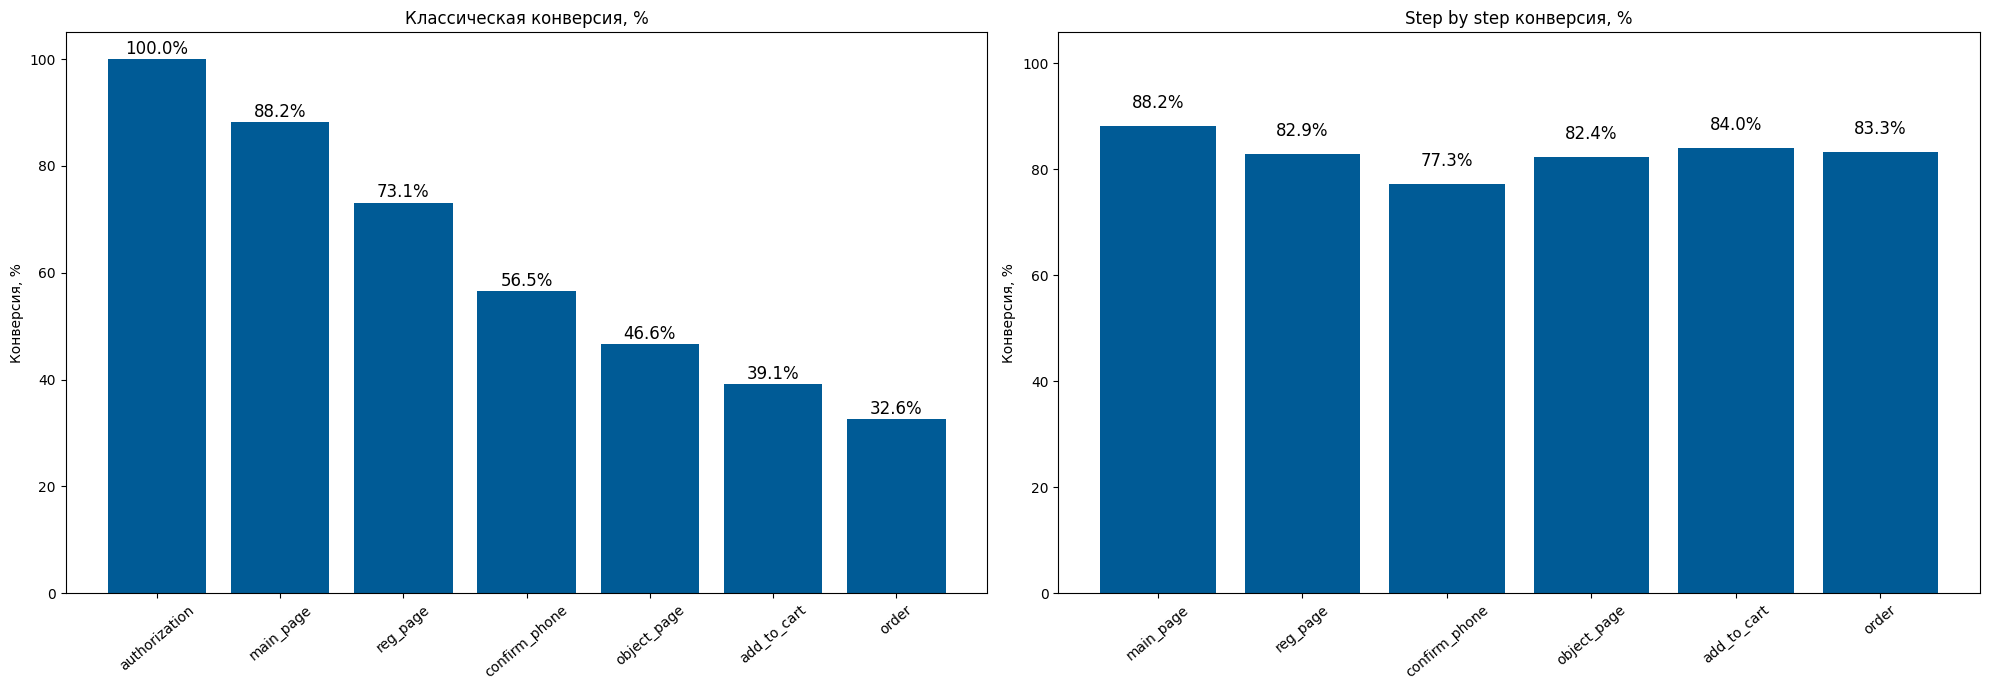

In [12]:
#строим визуализации
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

#классическая воронка
steps_classic = funnel['event']
conversions_classic = funnel['classic']

axes[0].bar(funnel['event'], funnel['classic'], color = '#005b96')
axes[0].set_title('Классическая конверсия, %')
axes[0].set_xticklabels(labels = steps_classic, rotation=40)
axes[0].set_ylabel('Конверсия, %')

#наносим значения конверсии на график
for index, value in enumerate(conversions_classic):
    axes[0].text(index, value + 1, f'{value:.1f}%', ha='center', fontsize=12, color='black')

#step by step воронка
steps_stbs = funnel['event'][1:]
conversions_stbs = funnel['step_by_step'][1:]

axes[1].bar(funnel['event'][1:], funnel['step_by_step'][1:], color = '#005b96')
axes[1].set_title('Step by step конверсия, %')
axes[1].set_xticklabels(labels = steps_stbs, rotation=40)
axes[1].set_ylabel('Конверсия, %')

axes[1].set_ylim(0, max(conversions_stbs) * 1.20)

for index, value in enumerate(conversions_stbs):
    axes[1].text(index, value + (max(conversions_stbs)*0.03), f'{value:.1f}%', ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()

Классическая воронка не показывает значимых аналомалий. На каждом этапе количество пользователей, совершивших действие снижается примерно на 10% по отношению к этапу авторизации.

Step by step воронка показывает снижение количества пользователей на этапе `confirm_phone`, что сигнализирует о возможных проблемах, с которыми сталкиваются пользователи при подтверждении номера телефона в мобильном приложении.

Построим step by step воронки конверсии для каждой версии приложения, для более детального понимания пользовательского пути.

### **Задача 2.2.** Сравнение пользовательского пути в мобильной и  desktop версиях приложения

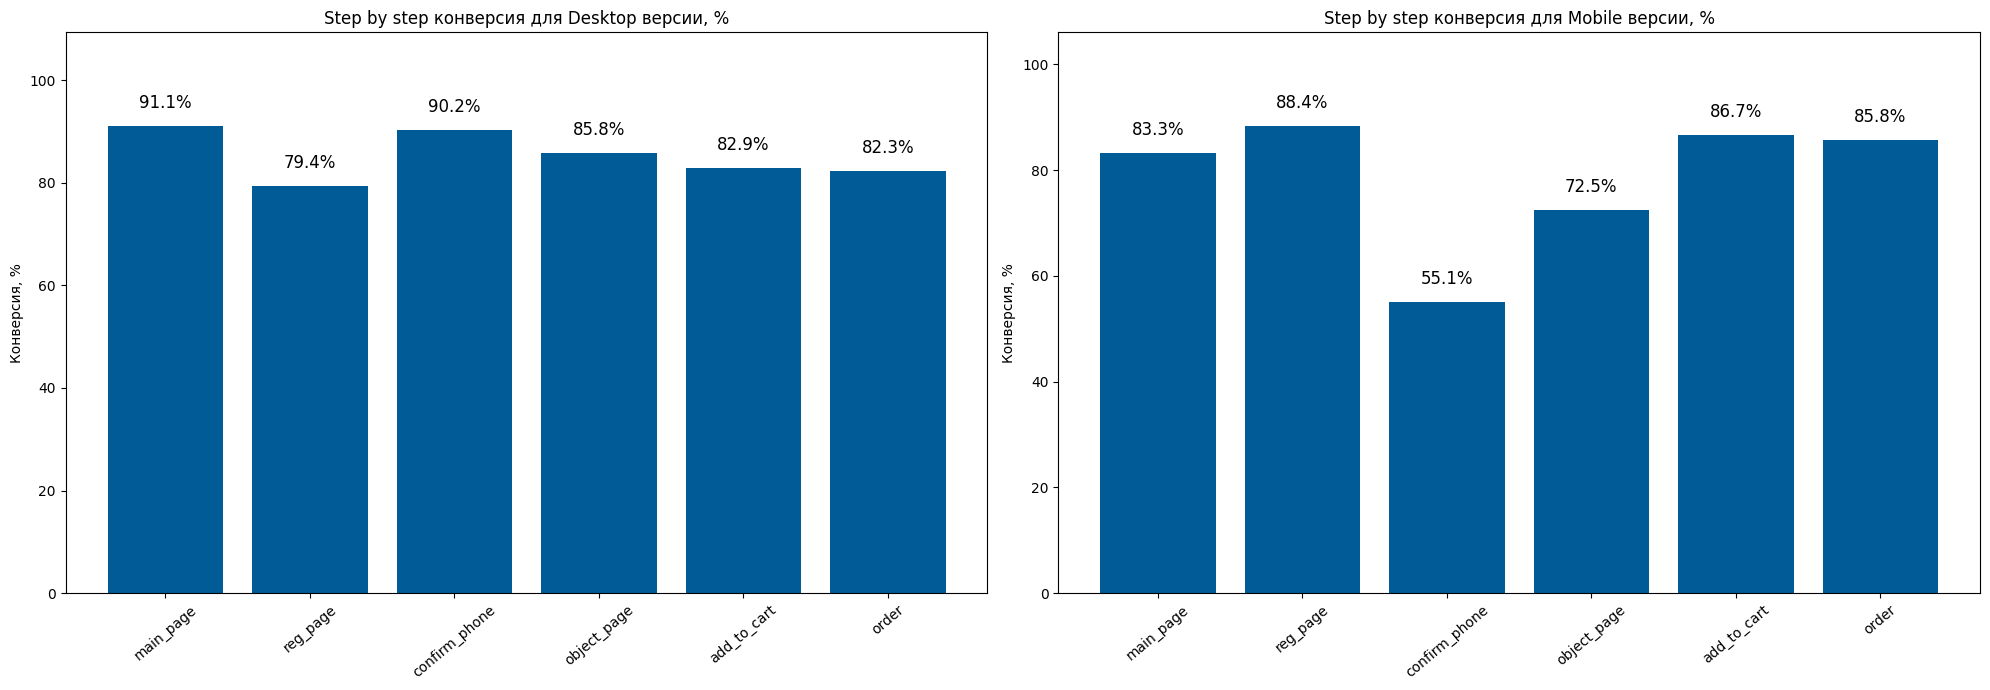

In [13]:
#рассчитываем step by step конверсию для каждой версии приложения
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

for device, ax in zip(['Desktop','Mobile'],[0,1]):
    #фильруем данные
    funnel_data = data[(data['event'].isin(steps)) & (data['device_type'] == device)].copy()

    #рассчитываем количество пользователей для каждого этапа
    funnel = funnel_data.groupby('event')['user_id'].nunique().reindex(steps).reset_index(name = 'user_count')

    #рассчитываем step by step конверсию
    funnel['step_by_step'] = (funnel['user_count'] / funnel['user_count'].shift(1) * 100).round(1)

    #строим визуализации
    bars = axes[ax].bar(funnel['event'][1:], funnel['step_by_step'][1:], color='#005b96')
    axes[ax].set_title(f'Step by step конверсия для {device} версии, %')
    axes[ax].set_xticklabels(labels = steps[1:], rotation=40)
    axes[ax].set_ylabel('Конверсия, %')

    #добавляем подписи значений
    max_conversion = funnel['step_by_step'][1:].max()
    axes[ax].set_ylim(0, max_conversion * 1.20)


    for bar in bars:
        height = bar.get_height()
        axes[ax].text(bar.get_x() + bar.get_width()/2.,
                     height + (max_conversion * 0.03),
                     f'{height:.1f}%',
                     ha='center', va='bottom',
                     fontsize=12, color='black')
#выводим результат
plt.tight_layout()
plt.show()

Существуют значимые различия в пользовательском пути для пользователей различных версий приложения.

Конверсия для пользователей desktop версии более равномерная. Заметен отток пользователей на этапе перехода на страницу регистрации. Это может быть связано с тем, что процесс перехода на страницу регистрации не совсем понятен для некоторых пользователей. Возможно стоит пересмотреть дизайн десктопной версии для того, чтобы сделать упростить процесс перехода к этапу регистрации.

Для пользователей мобильной версии приложения заметен значимый отток на этапе подтверждения номера телефона. Это сигнализиурет о том, что изменения в алгоритме подтверждения мобильного телефона и адреса доставки в мобильной версии приложения могли привести к ошибкам или существенному усложнению процесса завершения регистрации. Необходимо передать данную информацию в команду разработки мобильной версии приложения для проверки корректности работу алгоритма.

На этапах добавления блюда в корзину и оформления заказа конверсия для пользователей десктопной версии ниже, чем для пользователей мобильной версии. Возможно причина также кроется в неудобности дизайна десктопной версии приложения. В мобильной версии процесс добавления товара в корзину и оформления заказа более понятен пользователям.

## Вывод

Анализ классической воронки показал отсутствие значимых аномалий в пользовательском пути. Анализ step by step воронки показал отток пользователей на этапе подтверждения номера телефона, что потенциально могло быть вызвано сложностями, с которыми пользователи мобильной версии приложения сталкаются в мобильной версии при завершении регистрации.

Более детальный анализ step by step воронок в разрезе платформы подтвердил, что сильная просадка на этапе `confirm_phone` (до 55% по отношению к предыдущему этапу) наблюдается именно для пользователей мобильной версии приложения.

Анализ десктопной версии также показал, что отток пользователей происходит на этапе `reg_page` (конверсия составляет 79% по отношению к предыдущему шагу). Возможно стоит пересмотреть дизайн десктопной версии для того, чтобы сделать упростить процесс перехода к этапу регистрации.

Кроме того были замечены различия в конверсии между версиями приложения для этапов `add_to_cart` и `order`: для пользователей десктопной версии конверсия на данных этапах ниже примерно на 3 - 4%, что может быть связано с недостатками интерфейса десктопной версии приложения.

Информация будет передана командам разработки мобильной версии и UX-команде для проработки улучшений.

---

## 3. RFM сегментация

У сервиса доставки еды не такое высокое удержание пользователей: в первый день возвращается около 14% посетителей, а на седьмой день и того меньше — около 4–5%. Маркетологи хотят запустить несколько рекламных кампаний, направленных на удержание платящих пользователей и их возврат в сервис, если они давно не совершали заказы.

Для этого необходимо сегментировать пользователей на различные поведенческие сегменты с помощью RFM-сегментации по трём показателям:
- **давность** (Recency),
- **частота покупок** (Frequency),
- **сумма трат** (Monetary).

Дата анализа - **03 июля 2021 года**.

### **Задача 3.1.** Расчет recency, frequency, monetary_value

Рассчитаем для каждого покупателя:

- количество дней с последней покупки — давность (R);
- частоту покупок (F);
- стоимость всех покупок — сумму трат (M).

In [14]:
#устанавливаем дату анализа
curr_date = '2021-07-01'

#фильтруем данные для анализа
orders = data[data['event'] == 'order'].copy()

#находим количество дней с покупки до анализа
orders['order_recency'] = pd.to_datetime(curr_date) - pd.to_datetime(orders['datetime'].dt.strftime('%Y-%m-%d'))

#рассчитываем данные для RFM-анализа
rfm_data = orders.groupby('user_id').agg( # Количество дней с последнего заказа:
                                          recency = ('order_recency', lambda x: x.min().days),
                                          # Количество заказов за период времени:
                                          frequency = ('datetime', 'count'),
                                          # Сумма стоимости всех заказов:
                                          monetary_value = ('revenue', 'sum')).reset_index()

<div style="background-color: #d4edda; color: #155724; padding: 15px; border-radius: 4px; border: 1px solid #c3e6cb;">

<b>Комментарий ревьюера v1:</b>

Данные отфильтрованы верно.

Визуализируем получившийся результат.

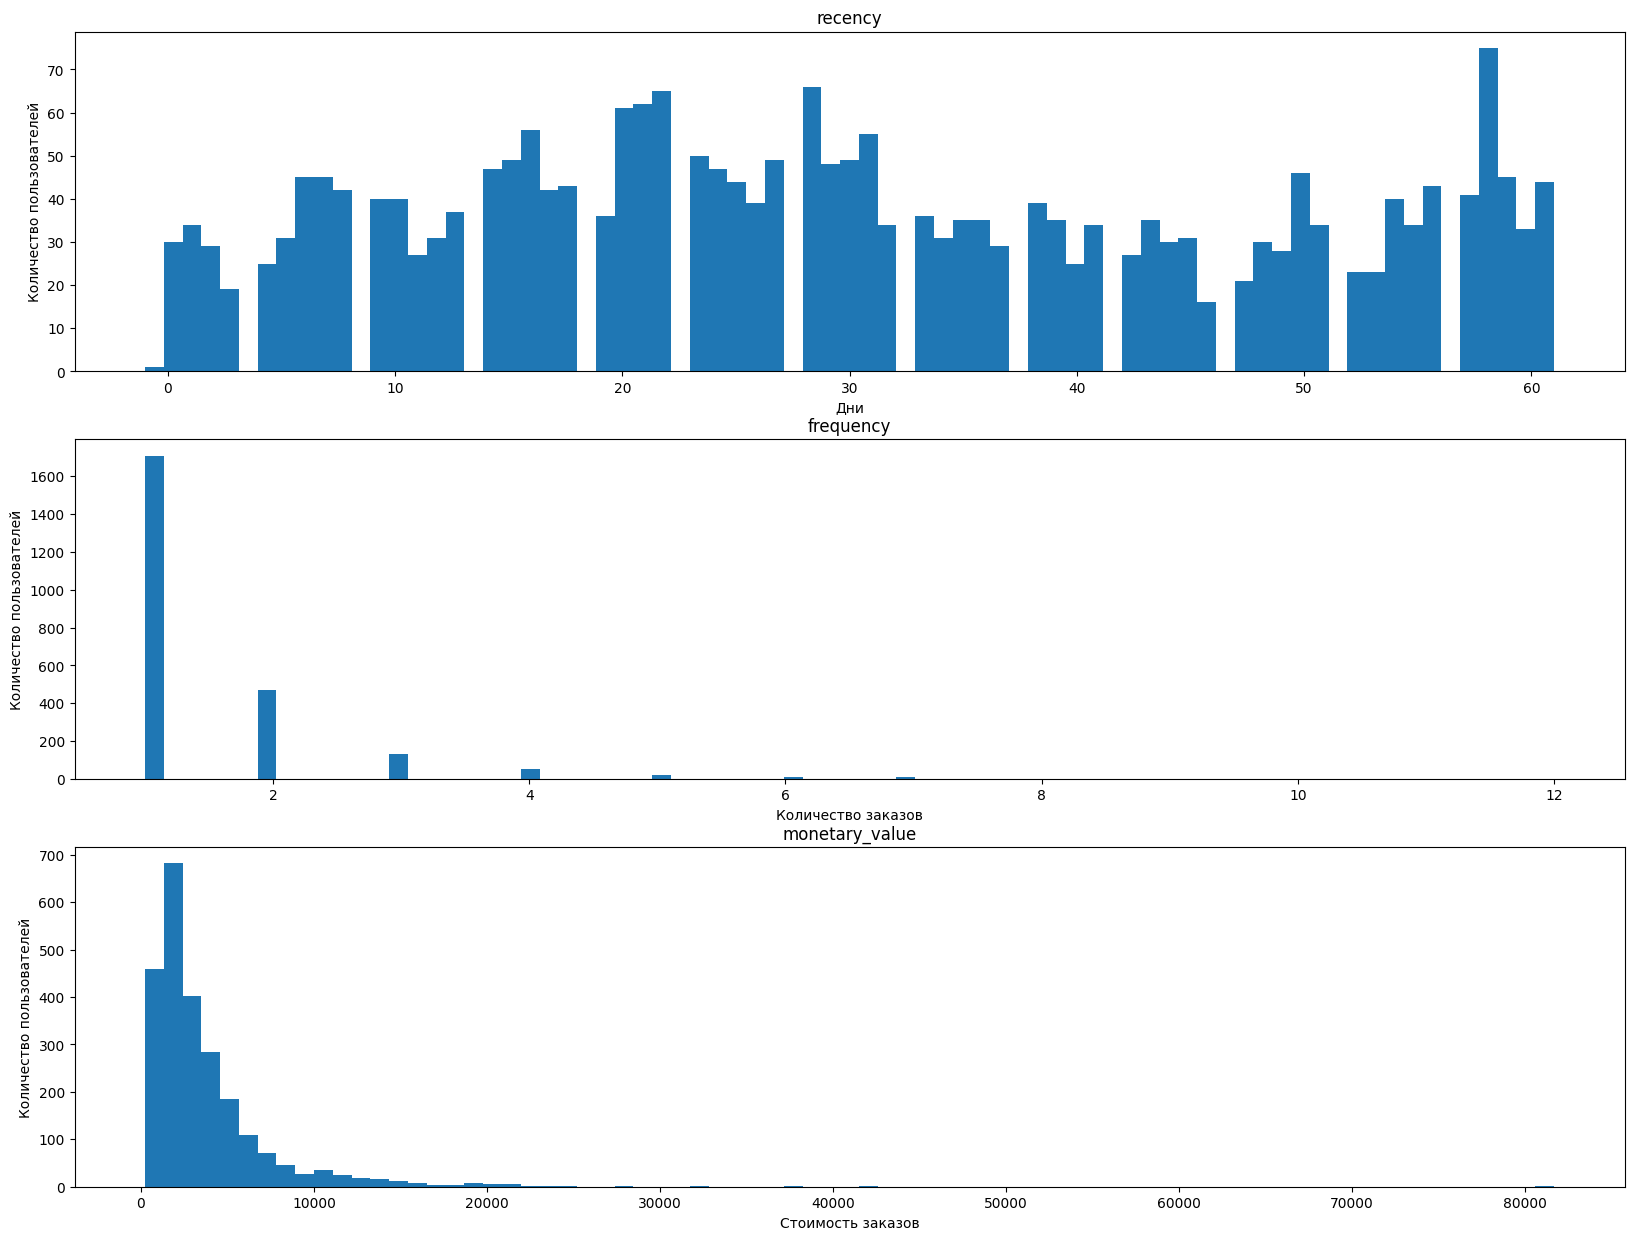

In [15]:
#строим гистограммы
fig, axes = plt.subplots(3, 1, figsize=(20, 15))

for criteria, ax, characteritic in zip(['recency','frequency','monetary_value'],
                                       [0,1,2],
                                       ['Дни','Количество заказов','Стоимость заказов']):
    axes[ax].hist(rfm_data[criteria], bins=75)
    axes[ax].set_title(f'{criteria}')
    axes[ax].set_xlabel(f'{characteritic}')
    axes[ax].set_ylabel('Количество пользователей')

plt.show()

Распределение пользователей по давности заказов достаточно равномерное. Среди пользователей примерно в равном соотношении встречаются как те, кто совершает заказы регулярно, так и те, кто оформляли заказы более 30 дней назад. Для выделения сегментов по давности лучше всего подойдет деление пользователей на три равных группы.

Распредеделение пользователей по количеству заказов неравномерное. Больше всего пользователей в группе с одним заказом. Среди пользователей практически не встречается тех, кто оформил более пяти заказов. Для выделение сегментов по количеству заказов разделим пользователей на 3 группы:

- пользователи с 1 заказом (F-сегмент с небольшим количеством заказов);
- пользователи с 2 заказами (F-сегмент со средним количеством заказов);
- пользователи с 3 и более заказами (F-сегмент с большим количеством заказов).

Распределение пользователей по стоимости оформленных заказов также неравномерное. Для большинства пользователей сумма оформленных заказов составляет менее 10 000 руб. Для выделения сегментов применим деление на три группы по 33-ему и 66-ому перцентилям.

### **Задача 3.2.** Выделение **RFM-сегментов** и изучение распределения пользователей по ним.

In [16]:
#делим пользователей на три равных группы по давности покупки
rfm_data['r'] = pd.cut(rfm_data['recency'], bins=3, labels=[3,2,1])

#определяем группы пользователя по количеству заказов
rfm_data['f'] = pd.cut(rfm_data['frequency'], [1, 2, 3, 12], labels=[1,2,3], include_lowest=True)

#определяем группы пользователя по стоимости заказов
rfm_data['m'] = pd.qcut(rfm_data['monetary_value'], q=3, labels=[1,2,3])

#находим RFM-индекс
rfm_data[['r','f','m']] = rfm_data[['r','f','m']].astype('str')
rfm_data['rfm_group'] = rfm_data['r'] + rfm_data['f'] + rfm_data['m']

#рассчитываем количество пользователей в каждом сегменте
rfm_data = rfm_data.groupby('rfm_group').agg({'user_id':'nunique'}).reset_index()

#находим долю пользователей в каждом сегменте
rfm_data['user_share'] = rfm_data['user_id'] / rfm_data['user_id'].sum()

#меняем наименования столбцов
rfm_data = rfm_data.rename(columns = {'rfm_group' : 'RFM-сегмент',
                                      'user_id' : 'Количество пользователей',
                                      'user_share' : 'Доля пользователей, %'})

In [17]:
#выводим результат
print(f'RFM-сегментация пользователей:')

f = {'Доля пользователей, %':'{:.2%}'}
rfm_data.sort_values(by = 'Количество пользователей',
                     ascending = False).style.format(f).bar(color = '#b2d8f7',
                                                            axis = 0,
                                                            subset = 'Доля пользователей, %')


RFM-сегментация пользователей:


,RFM-сегмент,Количество пользователей,"Доля пользователей, %"
8,212,296,12.25%
7,211,289,11.96%
0,111,263,10.89%
1,112,261,10.80%
15,311,255,10.55%
9,213,237,9.81%
16,312,234,9.69%
17,313,187,7.74%
2,113,160,6.62%
12,223,56,2.32%


## Вывод

Результаты сегментации сигнализируют о том, что большинство пользователей пользователей совершали заказы относительно недавно (об этом свидетельствуют преобладание цифр 2,3 по Recency), но на сравнительно невысокую сумму (преобладание цифр 1,2 по monetary_value). Заметно, что пользователи не возвращаются для оформления повторных заказов (преобладание цифры 1 по Frequency).

Отдельно стоит выделить большой сегмент неактивной аудитории "111", который составляет почти 11% от пользователей.

При этом сегменты самых лояльных пользователей "333", "323, "223" составляют около 5%. Данный показатель однозначно нуждается в улучшении.

Необходимо понять, почему пользователи не возвращаются к повторному использованию приложения и разработать меры по более эффективному удержанию: например, запустить программу лояльности с системой накопления кешбека. Это стимулирует пользователей оформлять заказы более часто. Для возврата пользователей давно не использовавших приложение, можно предложить им скидку на оформление заказа в приложении или бесплатную доставку, что поможет повысить их заинтересованность в продукте.

---

## 4. K-Means кластеризация

Чтобы лучше понимать поведение ресторанов и предлагать им персонализированные условия сотрудничества, а также создавать персонализированные предложения для пользователей, маркетологи запросили кластеризацию ресторанов по следующим параметрам:
- общее количество заказов;
- средняя стоимость заказа;
- общее число заказанных уникальных блюд (ассортимент ресторана).

С помощью метода K-Means разделим рестораны на кластеры, отражающие различные модели работы и целевые сегменты.

### **Задача 4.1.** Подготовка данных для кластеризации

Рассчитаем:

- общее количество заказов;
- средняя стоимость заказа;
- общее число заказанных уникальных блюд (ассортимент ресторана).

In [18]:
#агрегируем данные
rest_data = data.groupby('rest_id').agg({'order_id' : pd.Series.nunique,
                                         'revenue' : 'mean',
                                         'object_id' : pd.Series.nunique}).reset_index().rename(columns = {'order_id' : 'order_count',
                                                                                                           'revenue' : 'avg_order_price',
                                                                                                           'object_id' : 'dish_count'})

### **Задача 4.2.** Нормализация данных и расчет оптимального количества кластеров

Так как размерность признаков, используемых для кластеризации, обладает слишком большим разбросом, проведем нормализацию данных.

Для этого применим метод StandardScaler() из библиотеки sklearn.
Данный метод позволит привести данные к среднему значению 0 и стандартному отклонению 1.

In [19]:
#нормализуем данные
from sklearn import preprocessing

rest_data = rest_data[['order_count',
                       'avg_order_price',
                       'dish_count']]

values = rest_data.values
min_max_scaler = preprocessing.StandardScaler()
values_scaled = min_max_scaler.fit_transform(values)
rest_df = pd.DataFrame(values_scaled)
rest_df = rest_df.rename(columns = {0 : 'order_count',
                                    1 : 'avg_order_price',
                                    2 : 'dish_count'})
rest_df

,order_count,avg_order_price,dish_count
0,-0.076858,-0.202596,0.387545
1,-0.204212,0.484818,0.185765
2,-0.518699,-0.587033,-0.419573
3,-0.451123,0.151983,-0.554093
4,-0.443326,-0.622322,-0.397153
5,-0.406939,0.814218,-0.419573
6,-0.157429,0.567485,-0.195374
7,-0.529095,0.013507,-0.397153
8,2.722332,0.130563,2.920997
9,-0.531694,2.671462,-0.486833


Нормализация проведена успешно. Приступим к нахождению оптимального количества кластеров. Для этого воспользуемся методом `.inertia_`.

Визуализируем получившийся результат в виде графика.

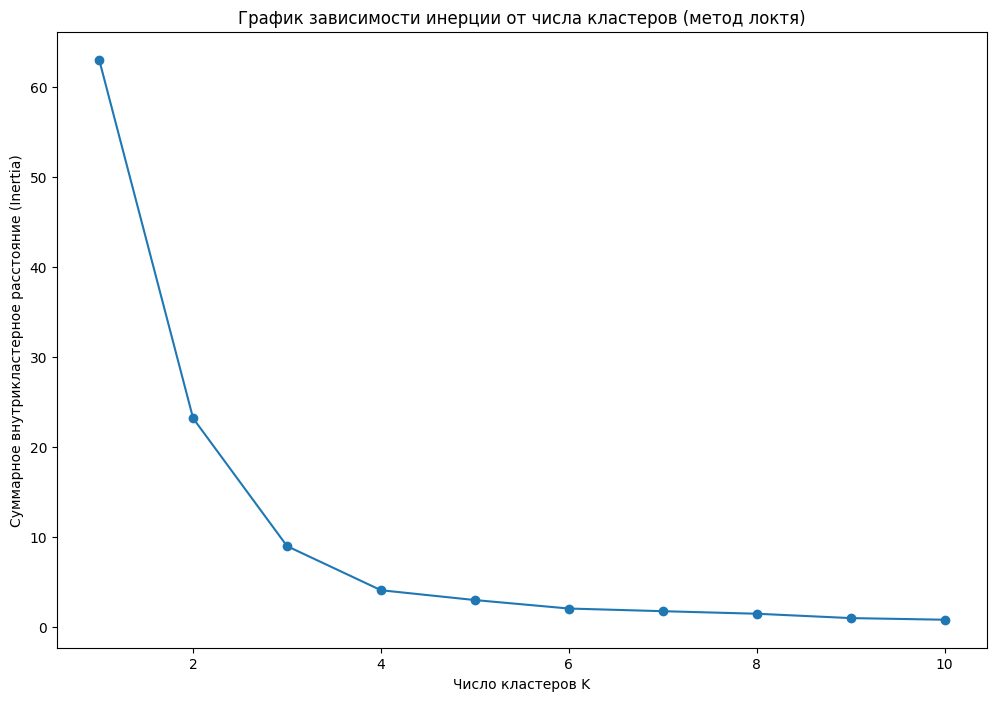

In [20]:
i = []

#задаем диапазон количества кластеров
min_k = 1
max_k = 10

plt.figure(figsize=(12, 8))

#перебираем значения в диапазоне
for k in range(min_k, max_k + 1):
   km = KMeans(n_clusters=k)  #создаем K-means для текущего количества кластеров
   km.fit_transform(rest_df)  #обучаем модель и получаем координаты точек в пространстве кластеров
   i.append(km.inertia_)  #сохраняем изначени inertia для текущего количества кластеров

#строим график зависимости inertia от количества кластеров
plt.plot(range(min_k, max_k + 1), i, marker='o')
plt.xlabel('Число кластеров K')  #добавляем подпись оси X
plt.ylabel('Суммарное внутрикластерное расстояние (Inertia)')  #добавляем подпись оси Y
plt.title('График зависимости инерции от числа кластеров (метод локтя)')  #добалвяем заголовок
plt.show()

График зависимости инерции от числа кластеров (метод «локтя») показывает "перелом" в значении 4. На основании этого можно предположить, что оптимальное количество кластеров составляет 4.

### **Задача 4.3.** Проведение кластеризации

Проведем кластеризацию, и рассчитаем средние значения по каждому кластеру.

In [21]:
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(rest_df)

#сортируем кластеры по возрастанию количества заказов
sorted_indices = np.argsort(kmeans.cluster_centers_[:, 0])
sorted_centroids = kmeans.cluster_centers_[sorted_indices]

#создаем датафрейм из центроидов
centroids_df = pd.DataFrame(
   sorted_centroids,
   columns=['Количество заказов', 'Средняя стоимость заказа', 'Количество блюд'],
   index=[f'Кластер {i + 1}' for i in range(kmeans.n_clusters)]
)

#форматируем значения с точностью до 2-х знаков после точки
pd.options.display.float_format = '{:.2f}'.format

#выводим результат
centroids_df

,Количество заказов,Средняя стоимость заказа,Количество блюд
Кластер 1,-0.35,0.41,-0.31
Кластер 2,-0.30,-0.76,-0.28
Кластер 3,-0.28,2.45,-0.46
Кластер 4,3.02,-0.08,2.98


На основании получившихся результатов можно выделить 3 кластера ресторанов:

- Кластер 1: Рестораны с самым низким количеством заказов, отнсительно высоким средним чеков и небольшим ассортиментом блюд;

- Кластер 2: Рестораны с низким количеством заказов, самым маленьким средним чеком и небольшим ассортиментом блюд;

- Кластер 3: Рестораны с низким количеством заказов, высоким средним чеком и небошльшим ассортиментом блюд;

- Кластер 4: Рестораны с высоким количеством заказов, сравнительно невысоким средним чеком и широким ассортиментом блюд.

Визуализируем результаты кластеризации, чтобы проследить зависимость признаков друг от друга. Построим следующие визуализации:

- средний чек в зависимости от количества заказов;
- количество блюд в зависимости от количества заказов.

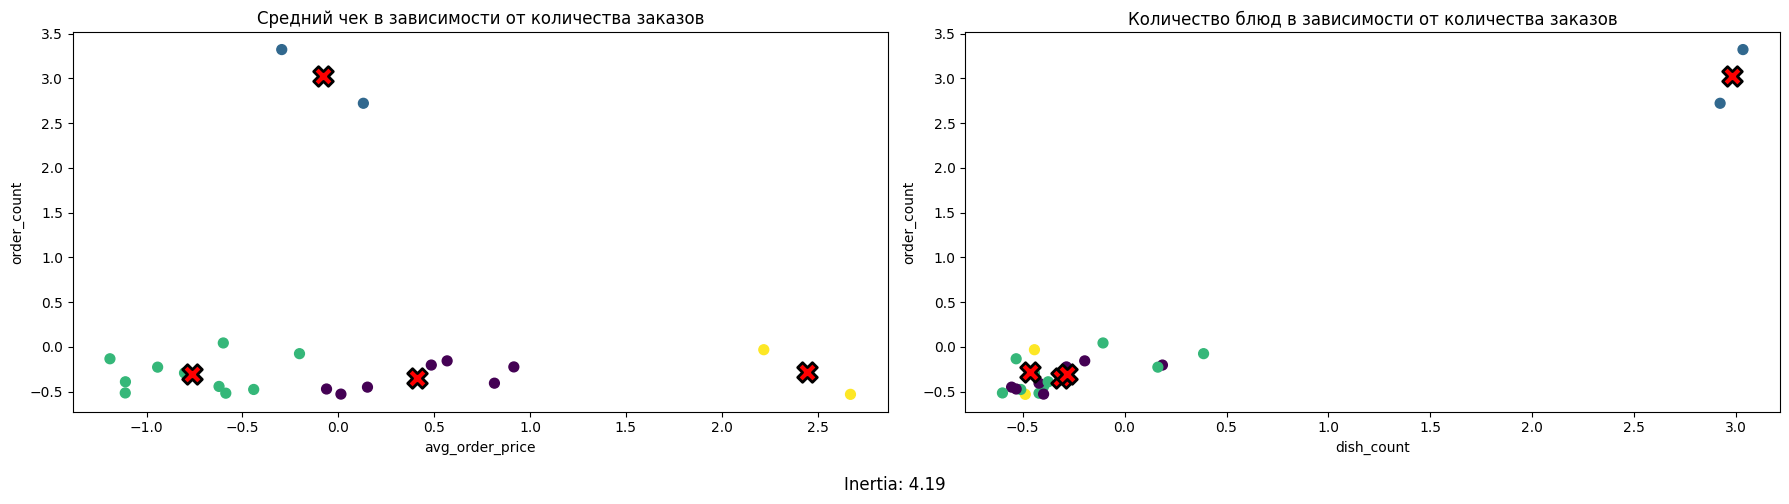

In [22]:
#находим координаты центров (центроидов) кластеров
centroids = kmeans.cluster_centers_

#создаем 2 графика
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

#обозначаем список признаков
axs = ['order_count','avg_order_price','dish_count']

#перебираем пары признаков (avg_order_price vs order_count), (dish_count vs order_count)
for i, (x_idx, y_idx) in enumerate([[1, 0], [2, 0]]):
   x_label, y_label = axs[x_idx], axs[y_idx]  # Названия признаков для осей

   #наносим точки на график
   axes[i].scatter(
       rest_df[x_label],  #значения по оси X
       rest_df[y_label],  #значения по оси Y
       c=labels,  #присваиваем цвет каждому кластеру
       cmap='viridis',  #задаем цветовую карту
       s=50  #задаем размер точек
   )

   #строим центроиды кластеров
   axes[i].scatter(
       centroids[:, x_idx],  #x-координаты центров
       centroids[:, y_idx],  #y-координаты центров
       s=200,  #устанавливаем размер крестов
       c='red',  #устанавливаем цвет крестов
       edgecolors='black',  #устанавливаем обводку
       linewidths=2,  #устанавливаем толщину обводки
       marker='X'  #устанавливаем форму маркера
   )

   # Подписи осей и заголовок графика
   axes[i].set_xlabel(x_label)
   axes[i].set_ylabel(y_label)

#устанавливаем заголовки
x_title, y_title = ['Средний чек в зависимости от количества заказов',
                    'Количество блюд в зависимости от количества заказов']

axes[0].set_title(x_title)
axes[1].set_title(y_title)

#подгоняем макет, оставляя место снизу для подписи с инерцией
plt.tight_layout(rect=[0, 0.05, 1, 1])

#добавляем текст с inertia
fig.text(0.5, 0.01, f'Inertia: {kmeans.inertia_:.2f}', ha='center', fontsize=12)

#выводим результат
plt.show()

## Вывод

График зависимости среднего чека от количества заказов показывает, что среди ресторанов втречаются как рестораны из более бюджетного ценового сегмента, так и более дорогие рестораны, которые пользуются одинаковой популярностью при оформлении заказов.

График зависимости количества блюд от количества заказов показывает, что невысокое количество заказов характерно для ресторанов с небольшим ассортиментом блюд.

Среди ресторанов можно выделить самый малочисленный кластер, который показывает высокие значения количества заказов при сравнительно небольшом среднем чеке и большом ассортименте блюд.

На основании полученных результатов можно предположить, что широкий ассортимент блюд в средней ценовой категории положительно влияет на количество заказов. Вероятно, при оформлении заказа пользователям важно разнообразие позиций и их цена.

---

## 5. Итоговый вывод и рекомендации

В результате проведенного анализа было выявлено следующее:

- Существуют значимые различия в пользовательском пути для пользователей различных версий приложения. Отток пользователей десктопной версии происходит на этапе перехода на страницу регистрации (снижение до 79% по отношению к этапу авторизации). Для пользователей мобильной версии приложения заметен значимый отток на этапе подтверждения номера телефона (до 55% по отношению к этапу перехода на страницу регистрации);

- Были замечены различия в конверсии между версиями приложения для этапов `add_to_cart` и `order`: для пользователей десктопной версии конверсия на данных этапах ниже примерно на 3 - 4%;

- RFM сегментация показала, что большая часть аудитории - совершала заказы недавно, на небольшую сумму, и не возращается к совершению повторных заказов. Доля сегмента неактивных пользователей составляет 11%, в то время как на лояльных пользователей приходится всего 5%;

- Кластеризация ресторанов показала, что широкий ассортимент блюд положительно влияет на количество заказов.

На основании полученных инсайтов можно дать следующие рекоммендации:

- Команде разработки мобильной версии приложения необходимо проверить корректность работы нового алгоритма подтверждения номера мобильного телефона, поскольку возможные технические неполадки могут приводить к оттоку пользователей на данном этапе;

- UX-команде необходимо пересмотреть дизайн десктопной версии для упрощения процесса перехода на страницу регистрации и для уменьшее оттока пользователей на данном этапе, а также упростить процесс добавления блюд в корзину и оформления заказов;

- Запуск программы лояльности с системой накопления кешбека поможет стимулировать пользователей оформлять заказы более часто. В результате сегмент лольяных клиентов может увеличться с 5% до 25%. Для возврата пользователей давно не использовавших приложение, можно предложить им скидку на оформление заказа в приложении или бесплатную доставку, что поможет повысить их заинтересованность в продукте. Это позволит вывести до 11% аудитории из неактивных в активных пользователей и поработать с их дальнейшим привлечением в сегмент лояльных клиентов;

- Для увеличения выручки, ресторанам с высоким средним чеков необходимо разнообразить ассортимент блюд. Более широкий ассортимент положительно скажется на количестве заказов.

Можно начать с проверки корректности алгоритма подтверждения номера телефона и адреса телефона в мобильной версии, что потенциально позволит повысить конверсию до уровня десктопной версии приложения (до 90%).

Проработка возвращения неактивных клиентов при помощи промокодов на скидку и акций также не требует длительной подготовки, но потенциально позволит вернуть до 11% пользователей в приложение.